## Testing Julia for GAIA

using the julia language for GAIA analaysis <br>

1. Testing the optimization of the dbscan
2. Testng Affinity propagation


In [17]:
using PyCall
using DataFrames
using Statistics

using Clustering 
using Statistics
using Distances

using Glob

push!(LOAD_PATH,"/home/stephane/Science/GAIA/master/src")
using GaiaClustering

import PyPlot; const plt = PyPlot

@pyimport astropy.io.votable as votable
# @pyimport matplotlib.pyplot as plt

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "/home/stephane/Science/GAIA/products"

cd(wdir)

In [18]:
## Transform PM from equatorial to galactic system.
## See Poleski 1997

function convert_PM(μα , μδ , α , δ )
    αG = 192.85948
    δG = 27.12825
    
    C1 = sind(δG)*cosd(δ) - cosd(δG)*sind(δ)*cosd(α - αG)
    C2 =  cosd(δG)*sind(α - αG)
    k = 1 / sqrt(C1^2 + C2^2)
    A = k * [C1 C2 ; -C2 C1]
    PMG = A * [μα ; μδ ]
    
    return(PMG)
end

convert_PM (generic function with 1 method)

In [19]:
#########
function _filter_data(gaia, dist_range = [0., 2000], vra_range = [-250,250], vdec_range = [-250.,250], mag_range =[-1e9, 1e9])::GaiaClustering.Df
########
    ngaia = length(gaia)
    
    lgal = zeros(ngaia)
    bgal = zeros(ngaia)
    ra = zeros(ngaia)
    dec= zeros(ngaia)
    distance = zeros(ngaia)  
    pmra = zeros(ngaia)
    pmdec = zeros(ngaia)    
    parallax = zeros(ngaia)
    vra = zeros(ngaia)
    vdec = zeros(ngaia)    
    g = zeros(ngaia)
    rp = zeros(ngaia)     
    bp = zeros(ngaia) 
    parallax_error = zeros(ngaia)
    pmra_error     = zeros(ngaia)
    pmdec_error    = zeros(ngaia)
    
    ## Galacti proper motion
    pml = zeros(ngaia)
    pmb = zeros(ngaia)
    
    for i in 1:ngaia
        lgal[i]     = convert(Float64,gaia[i]["l"])
        bgal[i]     = convert(Float64,gaia[i]["b"])
        ra[i]       = convert(Float64,gaia[i]["ra"])
        dec[i]      = convert(Float64,gaia[i]["dec"])
        distance[i] = 1000. / convert(Float64,gaia[i]["parallax"])
        parallax[i] = convert(Float64,gaia[i]["parallax"])
        pmra[i]     = convert(Float64,gaia[i]["pmra"])
        pmdec[i]    = convert(Float64,gaia[i]["pmdec"])
        vra[i]      = 4.74e-3 * pmra[i]  * distance[i]
        vdec[i]     = 4.74e-3 * pmdec[i] * distance[i]
        ### errors.
        parallax_error[i]  = convert(Float64,gaia[i]["parallax_error"])
        pmra_error[i]  = convert(Float64,gaia[i]["pmra_error"])
        pmdec_error[i] = convert(Float64,gaia[i]["pmdec_error"])
        
        g[i]        = convert(Float64,gaia[i]["phot_g_mean_mag"])
        rp[i]       = convert(Float64,gaia[i]["phot_rp_mean_mag"])
        bp[i]       = convert(Float64,gaia[i]["phot_bp_mean_mag"])
        
        muG = convert_PM(pmra[i],pmdec[i]  , ra[i] , dec[i])
 
        
    end
    
    ## Filtering ...
    i1 =  distance .> dist_range[1]
    i2 =  distance .< dist_range[2]
    i3 =  vra .> vra_range[1]
    i4 =  vra .< vra_range[2]
    i5 =  vdec .> vdec_range[1]
    i6 =  vdec .< vdec_range[2]
    i7 = g  .> mag_range[1]
    i8 = g  .< mag_range[2]
    i9  = rp  .> mag_range[1]
    i10 = rp  .< mag_range[2]
    i11  = bp  .> mag_range[1]
    i12  = bp  .< mag_range[2]
     
    ifinal = i1 .& i2 .& i3 .& i4 .& i5 .& i6 .& i7 .& i8 .& i9 .& i10 .& i11 .& i12 
    
    ## G magnitude
     # gbar =  g[ifinal] - 5. * log10.(distance[ifinal]) + 17.
    gbar =  g[ifinal] - 5 .* log10.(distance[ifinal]) .+ 17.
    
    ## Df of the filtered dat
    ndata = length(distance[ifinal])
    s = GaiaClustering.Df(ndata, zeros(8,ndata), zeros(10,ndata) , zeros(8,ndata) ) 
    
    s.data[1,:] = lgal[ifinal]
    s.data[2,:] = bgal[ifinal]
    s.data[3,:] = distance[ifinal]
    s.data[4,:] = vra[ifinal]
    s.data[5,:] = vdec[ifinal]
    s.data[6,:] = gbar
    s.data[7,:] = g[ifinal] .- rp[ifinal]
    s.data[8,:] = bp[ifinal] .- g[ifinal]
    
    s.raw[1,:] = ra[ifinal]
    s.raw[2,:] = dec[ifinal]
    s.raw[3,:] = lgal[ifinal]
    s.raw[4,:] = bgal[ifinal]
    s.raw[5,:] = parallax[ifinal]
    s.raw[6,:] = pmra[ifinal]
    s.raw[7,:] = pmdec[ifinal]
    s.raw[8,:] = gbar
    s.raw[9,:] = rp[ifinal]
    s.raw[10,:] = bp[ifinal] 
    
    ## Errors ..
    s.err[1,:] = parallax_error[ifinal]
    s.err[4,:] = pmra_error[ifinal]
    s.err[5,:] = pmdec_error[ifinal]
    
    println("## Filtering done ...")
    println("## Stars selected: $ndata")
    
    return(s)
end

_filter_data (generic function with 5 methods)

In [20]:
## Main program

voname = "NGC 1901-1.0deg.vot"

data       = read_votable(voname)
df         = _filter_data(data)
dfcart     = add_cartesian(df)
blck       = [[1,2,3],[4,5], [6,7,8]]
wghtblck   = [5.0,8.0,1.0]
norm       = "identity"

dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 

## Votable NGC 1901-1.0deg.vot read
[-45.4005, -36.182]
[33.8673, 3.01295]
[0.027425, -2.69661]
[-12.8272, 7.10329]
[-29.3499, -9.49285]
[-2.77932, -12.4324]
[-24.6107, 1.35776]
[-6.86744, 0.372099]
[-7.60581, 2.30357]
[-15.7452, 8.92532]
[-11.5889, 8.72868]
[-15.9724, -5.72941]
[-0.959378, 20.5115]
[-13.0375, 0.772973]
[0.791868, 0.72556]
[-9.59474, 3.10116]
[-11.9149, -5.11335]
[-250.695, 61.4696]
[-5.17484, -6.05102]
[-19.3266, 5.10966]
[-9.79116, -5.88894]
[-11.4292, 24.7047]
[-12.4251, 4.25037]
[-3.6002, 2.43101]
[0.840535, -14.5649]
[23.5802, -8.66995]
[-18.8894, 0.454103]
[-52.1273, 10.6626]
[-15.5508, 2.72275]
[-2.83373, 2.68344]
[-2.86859, 2.65344]
[-8.34152, -1.14808]
[-22.7761, -26.5084]
[-0.442036, 19.4504]
[-8.16876, 0.297897]
[10.1227, 19.7711]
[8.49476, 10.6576]
[-40.0234, 2.84105]
[-7.43618, 2.22647]
[-20.2906, 2.13304]
[-2.39147, -5.2988]
[-25.6363, 5.90614]
[6.79705, 6.77234]
[7.74726, -3.56665]
[-8.44764, -16.0901]
[-17.2575, -0.228125]
[-12.6051, 11.945]
[-6.10128, 

[-29.7475, 7.49872]
[-18.0577, 7.57174]
[-6.15468, -4.09699]
[18.4203, 15.1657]
[5.08212, 5.05976]
[-8.93744, -0.53415]
[5.84803, 9.00472]
[-21.0448, -3.80657]
[18.9932, -2.58385]
[-167.36, -0.738519]
[-15.9977, 2.42277]
[-15.3258, 14.332]
[-2.20785, 0.812764]
[-44.4197, -16.4396]
[-16.1283, -0.723439]
[-5.08917, 1.55775]
[-6.13475, -9.8155]
[-15.2452, 3.12135]
[-15.7267, -1.51518]
[9.19112, 14.9732]
[6.92548, 10.0034]
[97.4844, 195.745]
[-6.55383, 6.82799]
[-6.26495, 5.41411]
[-9.58512, 4.63015]
[-10.1193, 1.16494]
[-12.6059, -0.903713]
[-7.89473, 6.49209]
[-0.729224, 1.35627]
[-9.80707, 2.23386]
[-9.60716, 13.4699]
[-0.0350569, 3.35605]
[-4.75542, 3.53494]
[-11.0681, -3.16464]
[-17.5867, -3.64106]
[-8.65099, 10.4007]
[-12.8672, 0.189765]
[-27.6344, 18.1623]
[-7.02385, -5.80018]
[-3.05925, -6.9547]
[-7.6545, -2.16865]
[-21.775, -0.40972]
[-15.0275, 8.26584]
[-12.8499, 7.84167]
[-4.89923, 1.02338]
[-3.60608, -4.14878]
[-21.3674, -11.6905]
[-3.83043, 1.30951]
[-9.6749, -0.514295]
[-15.9

[-39.0838, 53.2956]
[-24.1812, 10.4269]
[62.1658, -17.4622]
[-8.07711, -10.5107]
[-23.9822, 12.8606]
[-11.3509, 2.25578]
[59.4758, 132.888]
[-7.19758, 0.915155]
[3.37991, 3.39611]
[-3.11039, 2.51146]
[-8.61289, 13.1011]
[-1.76443, 0.98884]
[3.98271, 5.0828]
[-10.2994, -8.30763]
[-20.0129, -0.685901]
[-11.6431, 3.43185]
[-12.581, -0.78304]
[-10.1704, 1.79617]
[-3.04414, 4.79289]
[-18.0562, 4.0891]
[-7.81945, -6.98782]
[-11.2246, -5.03043]
[-21.1393, 3.24369]
[16.5993, 27.6439]
[-4.76118, 7.54578]
[-66.1775, 12.4849]
[-20.6282, 2.96908]
[-4.28105, 6.42695]
[-5.82919, 5.22835]
[-8.76462, 1.3342]
[-19.1662, 2.19927]
[-12.9655, 5.17778]
[-33.7642, 9.18357]
[-6.39175, -16.8388]
[-8.33139, 7.89377]
[-14.7705, -0.370407]
[-6.40483, 1.3663]
[-2.59926, -0.0443411]
[40.6773, 46.6568]
[4.17901, 5.24207]
[-9.81785, -11.171]
[7.72543, 2.80263]
[-55.7969, -2.23187]
[-8.14896, -7.58683]
[4.60972, 4.66676]
[-9.11054, -1.52869]
[-5.30015, -2.55348]
[17.0511, 9.20148]
[-4.30775, 4.79196]
[-20.3554, -9.00

[-25.8288, -1.67881]
[-21.498, -17.5017]
[2.47259, 6.78567]
[-7.16776, -4.15629]
[-16.614, 11.6396]
[-53.7113, 12.965]
[2.44907, 4.42094]
[-95.6307, 6.71457]
[2.75921, 1.43102]
[9.31896, 0.827431]
[-10.5074, 9.4095]
[-18.0517, 4.48636]
[-11.3397, 5.89889]
[-12.7453, 1.09286]
[4.97515, 6.15389]
[-22.8841, 3.17321]
[-3.53954, -11.5029]
[-7.47948, 3.63082]
[-14.9279, 4.75573]
[-13.1321, 4.33106]
[-3.46246, 1.85052]
[-13.6364, 4.68752]
[-13.7973, 13.3216]
[-16.4923, 17.6632]
[-18.3826, 0.226226]
[-18.8976, 13.5669]
[10.3393, 1.15511]
[-25.2698, -1.68694]
[-1.3625, 9.72089]
[-7.96771, -9.60008]
[-7.29396, 3.02142]
[24.2007, 49.5875]
[-14.4217, 3.55429]
[-16.6346, 2.50512]
[-32.7179, -1.18432]
[6.20711, 3.06877]
[-3.2733, -0.19157]
[-11.97, 4.3858]
[-51.9081, -2.06258]
[-18.6776, 5.99173]
[-6.44535, 1.01347]
[-9.71742, 1.17106]
[-8.54862, 11.756]
[-7.32505, -14.1522]
[0.473743, -7.37066]
[-13.1153, -0.693458]
[-4.33212, -14.1365]
[-0.211212, 14.7088]
[-3.17229, -13.4956]
[-9.67576, -3.8763]


[-9.16461, 6.3112]
[-0.68281, 1.41992]
[-3.23299, -8.68984]
[-25.2089, 2.85831]
[-20.8828, 18.0937]
[7.22394, -2.12241]
[-1.9043, 1.48922]
[-14.8947, -1.24696]
[-7.28676, -2.13869]
[-10.6186, 7.24165]
[-12.9275, 7.0308]
[-8.22004, 2.17586]
[-39.6175, 1.02173]
[21.3279, 29.5294]
[-6.73286, 7.88196]
[-5.98716, 3.23372]
[-13.6781, 8.99455]
[19.0259, -5.01055]
[-11.6196, 7.40379]
[36.0681, 17.3548]
[1.90233, 2.71327]
[-21.1655, 8.99001]
[3.59381, 3.29587]
[-50.3173, 5.77047]
[-6.22402, 2.60591]
[-3.03908, -0.217445]
[15.8793, -4.32284]
[18.6411, -12.7984]
[-22.6758, 13.3596]
[-49.0679, 8.49433]
[-10.7327, -1.14739]
[-14.4315, 13.5184]
[2.34192, 3.25503]
[-13.9877, -4.93974]
[-9.70868, 1.39587]
[-15.3072, 7.04286]
[-2.21675, 2.16582]
[9.13184, 0.509502]
[-10.3272, 0.554884]
[16.067, 22.7415]
[-11.5407, 12.1978]
[-1.39319, 0.418526]
[-5.5973, 1.94855]
[-24.6397, 5.73645]
[-1.26365, 16.7]
[15.6965, 23.009]
[-10.6348, 5.02286]
[-6.93148, -0.131283]
[-4.04043, 26.5214]
[-8.83529, -1.20503]
[-2.

[0.883696, 2.35021]
[-7.1796, -4.32286]
[-5.70416, -5.0494]
[-6.58693, -2.33856]
[4.73489, 12.7747]
[-10.8898, 13.09]
[-8.70605, 3.27124]
[5.31586, -6.9883]
[1.37197, 9.2625]
[9.96376, -4.40539]
[-24.0748, 0.836033]
[-23.5761, 0.479916]
[-7.52662, 1.84397]
[1.7357, 3.53725]
[-28.6903, 3.51715]
[-6.22807, 0.511233]
[-3.0014, 6.78519]
[-2.79497, 2.14962]
[-16.4042, -4.19429]
[-14.8583, -0.13654]
[-23.6955, 4.87595]
[-0.145306, 9.07441]
[-17.1568, -6.07474]
[-26.2335, 8.20449]
[-1.83398, -4.2154]
[-23.2072, 13.8533]
[-1.41127, 0.901464]
[-3.77655, 5.18734]
[-3.29453, -9.82214]
[-3.02442, 8.44384]
[-9.73178, 13.1158]
[2.09264, -0.791327]
[1.35482, 3.17668]
[19.5973, -1.90602]
[-5.86201, 25.9968]
[-24.405, 9.72205]
[3.91002, -3.93448]
[1.77471, 37.0578]
[15.5769, -3.14417]
[-8.72664, 5.64956]
[-9.65627, -0.125722]
[-20.5965, 6.51828]
[-14.069, 8.32354]
[-14.3865, 0.8699]
[-4.05338, 3.36534]
[-9.87692, 13.4443]
[1.34893, 5.98615]
[2.49588, 5.79018]
[-6.03311, 4.63962]
[-6.78372, -1.74853]
[-

[-9.37105, 5.73161]
[-30.9622, 13.2115]
[-4.12361, 2.83997]
[-10.0562, 1.55555]
[12.3145, -6.44664]
[-9.34526, -1.14322]
[-7.83826, 3.80036]
[3.26073, 4.61538]
[3.12133, 4.23086]
[-11.9796, 2.7113]
[-1.46394, 0.98469]
[-31.3275, 1.06864]
[-4.03519, 4.22939]
[-32.8847, 25.3975]
[15.5317, -6.04728]
[2.19841, 7.55171]
[2.23046, 3.51213]
[-17.1461, 1.19284]
[-15.6312, 6.68001]
[-12.9052, -0.631046]
[-28.37, -11.382]
[-6.6787, -11.2102]
[-12.2387, 1.08292]
[19.4998, 51.4389]
[-17.38, 1.93217]
[-19.0912, 6.01342]
[13.6388, -15.0136]
[-6.53468, 3.09015]
[20.9956, 28.0957]
[-8.33996, -0.597147]
[3.20474, 1.56076]
[15.121, 12.1812]
[-1.05207, -4.54637]
[-7.23275, 3.30137]
[-13.4595, 2.00847]
[-23.0877, -1.35685]
[18.2231, 6.86389]
[-6.32596, 7.34664]
[-5.51773, -0.313439]
[-13.4763, 0.516226]
[-0.369775, 9.75385]
[-9.60545, 2.46297]
[-0.802243, 1.11407]
[-13.8579, 7.03825]
[-8.76918, 0.505515]
[-8.9245, 3.0807]
[1.79346, 4.43701]
[2.66375, 1.64184]
[0.893579, 0.995832]
[-28.3905, 5.19187]
[4.13

[-8.95842, -0.480371]
[-22.1867, 13.2805]
[-10.1612, 26.9581]
[-15.2119, 0.963843]
[-7.08179, -15.2412]
[-18.9286, 6.63236]
[2.76602, 3.34588]
[-10.6222, 1.66792]
[14.5677, -2.54195]
[-2.8907, 1.55596]
[-7.2018, 10.9813]
[5.57644, -0.408895]
[-3.87663, 0.306449]
[-23.6802, 6.31182]
[-21.9115, -1.68031]
[-62.363, -24.6139]
[-0.941502, -1.59447]
[-28.247, 14.76]
[-3.81077, 0.672998]
[-7.16664, -6.88775]
[-6.22726, -0.293278]
[-11.9567, -6.80178]
[11.1115, 16.2105]
[-18.7542, -4.89391]
[-12.4711, 1.21593]
[-4.49268, -3.94218]
[3.35563, 1.91694]
[7.28371, 6.54965]
[-3.01251, 1.53677]
[-8.0478, -4.17956]
[-61.4792, -25.8186]
[-20.7348, 7.56487]
[30.3915, 0.996236]
[-8.38822, 5.14862]
[1.83718, 2.69031]
[10.7897, 8.99209]
[-9.54546, 1.70669]
[-14.8284, 5.19424]
[3.66895, -5.66236]
[-2.33414, 1.37342]
[-5.81894, 4.7009]
[5.12032, 14.15]
[-38.8927, 17.7295]
[-6.26752, 1.85461]
[19.3437, 11.8405]
[-1.81163, 1.59613]
[7.64835, 7.69437]
[-4.88928, 4.09465]
[-4.45891, -1.32035]
[-69.6554, -5.56521

[-7.20334, -6.77412]
[-12.9069, 2.01635]
[-22.3601, 7.50355]
[-2.6431, 1.28104]
[-8.96147, 3.21424]
[-6.70266, 6.18867]
[-1.58783, -1.75203]
[-37.0624, 3.38452]
[1.51193, -2.40821]
[-19.0131, 4.1721]
[-1.19053, 8.71473]
[-12.8882, -11.7757]
[3.56526, 29.788]
[21.3413, -9.17843]
[-5.46654, 4.33566]
[7.37528, -2.27305]
[-2.70686, 4.9864]
[-9.48872, 2.8196]
[-12.5126, 6.5763]
[-32.2447, 0.477863]
[-12.8709, -0.217485]
[-31.8408, 26.3279]
[-18.2032, 9.74626]
[-12.4011, 1.66351]
[-10.1384, 7.20617]
[-6.10412, -4.33525]
[11.6299, -3.57941]
[-1.21567, 1.40849]
[-15.8853, -1.6364]
[19.1883, 9.44159]
[-1.95428, 2.20361]
[-24.0917, 8.31106]
[2.09548, 2.92338]
[-12.6132, -3.17288]
[-13.6436, -12.9853]
[12.8537, 8.53778]
[-15.2271, 2.98389]
[-6.73085, 3.18142]
[-4.66726, 4.46968]
[35.935, -16.2356]
[-44.3026, 2.08115]
[-55.4382, 30.817]
[20.8257, 0.338387]
[13.7257, -9.65612]
[-7.04942, -4.52941]
[-19.8805, -0.937332]
[-8.50874, 11.8969]
[7.4077, 11.5084]
[-30.5172, 4.11498]
[4.57354, 8.55904]
[-2

[-13.1458, -4.64069]
[-38.721, 5.86022]
[-26.3983, -2.09406]
[-6.05872, 4.92577]
[-17.1077, 1.66992]
[-16.7252, -5.50252]
[10.366, 5.58721]
[-13.1055, 0.345357]
[13.3588, 9.12953]
[-4.40752, -2.15998]
[-10.4204, 10.558]
[-23.855, 11.6617]
[-6.17444, -1.65757]
[-11.2444, 0.357991]
[-22.9076, 15.3019]
[-10.2818, 4.81601]
[-14.4366, 7.49828]
[-9.81668, 7.5533]
[0.382601, 16.665]
[-0.254385, -5.06661]
[-5.63801, 6.91188]
[-6.71842, -3.16124]
[-50.0385, -18.895]
[-15.0223, 7.37979]
[-11.195, -3.3451]
[-3.12956, 1.9982]
[-19.0702, -8.15255]
[9.81129, -14.2686]
[-43.1781, -3.76877]
[-8.78003, 2.45884]
[-3.96468, 8.25428]
[-4.11355, 3.92784]
[-4.23412, 12.1452]
[-56.3084, 4.75715]
[-6.49248, 1.46308]
[-12.7776, 2.69072]
[1.78155, -0.758747]
[-15.0715, -3.49818]
[-14.6388, 3.29748]
[-0.28289, 3.8315]
[-10.208, 2.09116]
[-23.6705, 4.84962]
[-19.0429, -0.335462]
[2.7687, 6.71625]
[-2.37427, 1.82592]
[-15.7029, -5.93024]
[-24.5467, 14.0303]
[-25.4201, 7.27418]
[-11.6158, 1.21983]
[-29.6134, 18.127

[-14.5374, -2.43185]
[-3.36789, -8.07876]
[22.4155, 29.3959]
[-31.2506, -4.80259]
[1.5215, 13.0184]
[-10.9478, 11.2868]
[-15.3656, -6.93946]
[9.67391, -1.21715]
[-14.7006, 5.90428]
[-16.5874, 7.40985]
[23.3466, -0.427034]
[-22.2445, 6.4965]
[-20.5871, -0.64115]
[-20.981, 5.73195]
[10.1061, -1.50703]
[0.0286948, 8.65343]
[-10.0009, 6.71075]
[-5.12338, -8.78245]
[-21.3344, -10.1337]
[28.5806, 3.40724]
[-12.558, 4.18624]
[21.3926, -8.06671]
[21.4809, -7.59796]
[6.13055, 21.345]
[-0.767982, 12.9574]
[3.41622, -2.40723]
[15.7842, -3.56909]
[-222.253, 805.446]
[4.13375, -2.64113]
[-12.3583, -7.30492]
[-13.297, 2.98775]
[-5.08522, -32.7218]
[-13.8865, -2.3928]
[14.951, -12.3507]
[2.44282, 11.6804]
[3.69052, 4.01258]
[-48.8757, 14.4777]
[-3.4775, -5.96723]
[28.4314, -9.06906]
[23.5078, 19.3858]
[20.5796, -15.2264]
[-27.8417, 21.1906]
[-30.9116, -3.14344]
[-39.3503, 7.61965]
[-0.0306493, -15.7451]
[-1.70793, 1.26241]
[-9.07784, -5.22377]
[-33.8194, -9.96378]
[-4.82659, 46.6864]
[-15.0008, -3.81

[-18.4427, -11.0613]
[-17.8091, -1.86718]
[-13.065, -0.647794]
[0.129998, 14.0234]
[-27.4514, 4.82095]
[-20.1177, 6.25979]
[3.28099, -3.98194]
[-2.42182, 7.79631]
[-4.64651, -9.30062]
[-38.0731, 5.21097]
[-23.5605, 4.29039]
[-15.8826, 4.5021]
[-5.2245, 5.50653]
[3.34553, 0.848085]
[-7.25845, 2.17818]
[-7.49304, 7.06475]
[-12.4593, 3.58693]
[3.21601, -0.299181]
[7.75041, -3.40374]
[-4.61079, 0.668201]
[-2.12961, 1.75793]
[-1.35068, -1.78725]
[-12.8547, 0.109513]
[-10.5921, 6.28144]
[-1.44937, 2.57554]
[-23.1853, 30.2289]
[-5.91282, -8.42298]
[-3.63225, 6.66103]
[-15.4667, 3.81527]
[-3.15409, 3.50101]
[-31.7791, -13.4287]
[19.2164, 8.3515]
[-3.08797, 12.8275]
[-8.95104, 5.523]
[-17.613, -5.18881]
[-5.13293, 2.7374]
[-12.3149, 1.55417]
[-6.16454, -6.31717]
[-42.3902, 11.3578]
[-17.2272, -6.43737]
[3.61511, -5.98148]
[-29.0633, -2.50697]
[-9.06968, -3.1535]
[-13.007, -0.795643]
[-13.3799, 3.50571]
[-12.3887, 5.45296]
[-9.11583, -3.56444]
[-12.4032, 3.61413]
[-4.10905, -0.216091]
[-10.224, 

[-6.50489, 0.913792]
[8.36277, 5.31963]
[-51.9741, 39.2919]
[-4.26171, 5.54383]
[-2.99398, 1.42407]
[-7.93941, -0.248336]
[11.8685, -3.44704]
[0.651371, -13.6295]
[9.12784, 17.3144]
[-19.7951, 2.87977]
[-4.69859, 1.80203]
[-10.4631, 6.17449]
[2.008, 4.54027]
[2.24187, -5.31728]
[-12.9482, -0.831616]
[-7.00788, 4.74164]
[-1.5133, 3.96072]
[-15.3915, -4.3446]
[-1.32002, 3.37154]
[-4.60953, 6.22892]
[-5.62822, 4.6784]
[-14.5458, 0.443596]
[-6.88817, 8.12275]
[-11.3237, -11.5721]
[6.47799, -6.37266]
[-7.69412, 2.96132]
[10.1316, 18.655]
[-7.64037, 9.90836]
[-8.41985, -2.69786]
[-6.96544, 1.64082]
[-12.8527, 3.39528]
[-5.22061, -10.8662]
[1.85827, -2.9634]
[-18.396, 3.44873]
[-0.601197, -2.28439]
[15.8938, 25.0626]
[-4.85843, 3.29679]
[-7.22099, -20.1978]
[-31.4955, 2.90675]
[-15.6869, 4.06747]
[-11.5693, -4.37988]
[-4.57058, -5.95547]
[-17.364, 12.0622]
[-4.17051, -3.32601]
[-29.4777, 2.76492]
[-12.2835, -3.77794]
[-1.79688, -0.150994]
[12.0698, 23.8342]
[-3.35874, -13.4283]
[22.5755, -1.2

[-7.44866, -4.52702]
[-11.4819, 1.94864]
[3.05717, 5.79526]
[-10.3384, 3.51157]
[11.4182, 20.8075]
[-125.723, -28.9402]
[-8.12531, 5.31647]
[-9.72442, 7.65216]
[-21.848, 6.79422]
[12.7619, 26.2083]
[-13.1219, 1.32897]
[-87.6417, 24.9797]
[-17.6637, 9.19037]
[-9.9598, 1.49959]
[6.34496, -15.937]
[12.4553, 0.264944]
[0.932611, 3.38424]
[-12.5067, -0.301192]
[4.80563, 15.9696]
[-14.2651, -4.84226]
[-2.78108, 9.64738]
[-18.3142, -26.0165]
[-13.2134, 3.27601]
[28.1057, 0.0805532]
[-12.8537, -0.0934511]
[-14.3025, 1.63273]
[-12.1448, 0.0876162]
[-22.012, 3.69256]
[7.912, -1.84783]
[-13.2365, -10.6863]
[-30.2159, 5.15136]
[5.22933, -2.77877]
[-13.9112, 7.76372]
[-12.7414, -0.809613]
[10.3014, -5.69439]
[-1.87109, 2.45047]
[-24.9736, -3.6572]
[-5.88422, 2.53004]
[-20.6479, -1.13607]
[-9.4538, 7.21268]
[-20.9989, 4.34348]
[-22.0156, 11.5662]
[-24.1952, 8.69943]
[-13.0389, 4.62808]
[-10.6088, -6.24079]
[-7.20474, 1.10992]
[-35.5248, 1.14006]
[-11.3568, 0.848017]
[-6.28732, 0.115757]
[-13.8697, -

[7.3767, -2.39739]
[-14.1274, 9.40104]
[2.1988, 5.98122]
[-9.57174, -32.9327]
[-4.79339, 3.21391]
[-4.24086, 1.05588]
[7.24929, -0.757103]
[1.17388, 4.11544]
[-15.7415, 1.95927]
[4.33209, 4.23686]
[1.09973, 2.61279]
[14.1716, 4.46824]
[-0.196395, 11.1854]
[-3.69867, 0.481881]
[6.10932, 5.5322]
[-27.1188, -41.064]
[-18.4081, 11.1063]
[10.4222, 1.09046]
[-0.656012, 1.30206]
[-29.243, 10.8491]
[-5.25176, 0.183093]
[-2.34975, 1.00336]
[-10.3437, -1.23738]
[8.40502, 8.34093]
[2.07007, 2.89304]
[-7.67426, 0.723863]
[-18.5045, 4.01096]
[-16.4489, -7.47431]
[7.84376, 12.3226]
[-25.9146, -28.2066]
[104.345, 158.32]
[-0.664735, 1.32825]
[-22.766, 2.23494]
[10.9519, -2.20631]
[-3.19399, 2.03024]
[-1.42786, 26.3419]
[-10.8367, 5.41806]
[-6.90231, -0.629487]
[-7.75334, 0.072739]
[34.4138, 10.8781]
[21.4596, 6.70404]
[-26.3216, 1.68765]
[-7.99088, 8.8483]
[-5.55887, 6.59799]
[-1.11152, -9.24536]
[-6.74645, 6.21433]
[-19.6767, -7.37152]
[-9.66097, 3.3953]
[-17.7011, 1.18144]
[-16.5346, 34.2616]
[-16.

[-1.52102, 3.81231]
[-5.39305, 1.21872]
[-17.0496, 6.5687]
[-38.9356, 5.85735]
[-17.2278, 5.76996]
[32.9121, -4.08605]
[-7.27719, -5.75768]
[-8.22825, 4.66631]
[-35.7103, -10.1244]
[-48.8833, 9.4407]
[-15.7397, 8.87873]
[-6.60363, 3.07048]
[-6.70712, 1.32427]
[-8.1896, -0.220569]
[6.46964, -8.53757]
[-9.11952, 4.41862]
[-8.96986, 3.67263]
[-0.990892, 1.47486]
[-4.67395, 1.64288]
[-8.8712, -2.72752]
[-5.81458, 3.40181]
[-26.4629, -32.2315]
[27.5524, 23.9762]
[33.3928, -8.10541]
[-35.7251, 3.04332]
[44.0645, -5.47177]
[-9.02533, 3.09812]
[-12.8708, 4.06651]
[15.884, 37.8494]
[-56.8407, 9.52793]
[-2.42958, 2.31319]
[-11.2615, 0.806977]
[-33.5975, -38.0364]
[-20.3063, 7.92366]
[3.35129, 3.64044]
[5.38433, 6.68627]
[5.93547, 4.0144]
[5.56595, 39.4031]
[-6.8028, 7.84233]
[-3.40271, 6.33073]
[0.938674, 3.2936]
[-4.05101, -5.08604]
[-41.447, 4.55663]
[-7.00381, -9.23855]
[-10.2711, -21.1263]
[3.21439, 6.71223]
[2.56734, 3.03412]
[-22.6209, 7.25767]
[-3.53037, -5.16026]
[-1.98477, 1.70329]
[-15

[4.44958, -1.23481]
[-9.23066, 0.599995]
[3.31881, 5.88694]
[-12.3503, 1.68123]
[-4.28126, 1.94838]
[-23.3287, 3.29022]
[19.4859, -3.98672]
[-15.8312, -16.6896]
[22.3224, -6.82582]
[-4.95104, 3.94659]
[2.33641, 5.76774]
[-19.5683, 7.31348]
[-11.975, 2.54216]
[4.00773, 8.37618]
[-12.7124, 1.19741]
[-15.4843, 9.79455]
[-9.57893, 4.77043]
[2.70251, -0.894867]
[-41.1483, 2.37046]
[-30.0796, 5.89358]
[-6.09899, 0.819889]
[-17.857, 6.38704]
[2.20342, 6.50572]
[-5.86827, -5.99296]
[-65.5952, 19.9759]
[-7.20272, 3.29361]
[-6.37435, -0.22751]
[-24.839, -1.28078]
[-12.4983, 2.66073]
[14.6087, 10.1194]
[-11.3038, -1.27536]
[-2.42522, 6.96143]
[-13.148, 7.88384]
[1.51133, 1.17755]
[-46.7056, 31.633]
[-17.5684, 0.742394]
[2.20189, 5.75237]
[-11.2373, -5.2004]
[-0.930541, -5.3232]
[-30.9178, 6.5423]
[6.03802, -0.133547]
[7.25169, 17.0632]
[-4.14599, 1.97105]
[-13.1357, 19.9487]
[6.60337, 13.9013]
[-13.2666, 21.2826]
[-9.43911, 6.36691]
[-7.8967, -6.76077]
[-11.4596, 1.79823]
[-12.0789, 0.0288114]
[-

[-27.8172, 4.27197]
[-22.6999, 2.93137]
[-20.5707, -23.1359]
[-6.60712, -3.97488]
[-13.8981, -1.28248]
[-28.3672, 0.808592]
[4.34518, 4.53621]
[-5.08381, 2.64337]
[17.8377, -4.29502]
[15.3668, -4.37394]
[-33.6149, -37.632]
[-11.4394, 0.831563]
[-0.287852, 3.49874]
[-35.077, -7.41682]
[-12.6401, 1.32168]
[-7.72029, 2.10753]
[-17.2444, 1.58322]
[-24.3542, -28.2536]
[-14.1408, -8.84939]
[-1.68428, -3.19297]
[-8.5892, 1.90865]
[-6.25531, 0.925136]
[-45.3348, -0.967896]
[-8.64851, 0.196924]
[0.597469, 2.72635]
[-15.452, 2.78112]
[-7.41043, 2.12202]
[9.75697, 10.0487]
[0.818334, 2.01205]
[-29.7298, -2.1703]
[-15.8586, 6.69318]
[-3.43259, 1.51123]
[-4.88293, 4.73274]
[13.331, -1.22222]
[-2.92584, -7.47861]
[-1.49479, 2.45995]
[2.16936, 3.69434]
[4.17424, 6.87951]
[-2.08073, 1.5842]
[-28.3198, -6.7705]
[5.41885, 4.02595]
[-83.7563, -0.221317]
[18.9855, 14.9435]
[-8.47525, 4.23678]
[-13.3814, -22.534]
[-4.96202, 2.0394]
[-15.7253, 0.156549]
[8.99953, -2.17986]
[-29.3647, 4.44009]
[-13.2315, -1.

(GaiaClustering.Df(5382, [134.808 581.644 … 554.738 82.9952; 0.850881 4.01957 … -3.02822 -0.465962; … ; 0.106127 0.0445453 … 0.041571 0.064911; 0.014714 0.0348366 … 0.028679 -0.000125848], [79.0883 78.6382 … 77.1658 77.1746; -68.7346 -68.7292 … -68.0068 -68.0001; … ; 17.9101 11.092 … 15.4264 18.263; 19.6445 12.2314 … 16.4346 19.1929], [0.329563 0.0234406 … 0.0389376 0.57341; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), [0.348367, 0.348367, 0.348367, 0.557386, 0.557386, 0.0696733, 0.0696733, 0.0696733])

In [21]:

## Clustering ..
println("## Starting Clustering ...")


###########################3
eps = 4.5

println("ϵ : $eps")

dftemp = copy1(dfcartnorm)

println("## dbscan..")
res1 = dbscan(dftemp.data , eps , leafsize=20, min_neighbors=10, min_cluster_size=25)
println("### done ...")

println("## Ward")
d = pairwise(Euclidean(), dftemp.data, dftemp.data)
res = hclust(d)
println("### done ...")

# println(res.order)
# println(res.heights)

ind = findall( x -> x < 1.0, res.heights)

indx = res.order[ind]
println(length(indx))

i = 1
for cl in res1
    println("i : $i")
    i += 1
    indx1 = cl.core_indices
    append!(indx1, cl.boundary_indices) 
    println(length(indx1))
    mean1 = mean(dfcart.data[1,indx1])
    lgal1 = mean(df.data[1,indx1])
    bgal1 = mean(df.data[2,indx1])
    println("Mean: $mean1")
    println("lgal : $lgal1")
    println("bgal : $bgal1")
end
indx = res1[1].core_indices
append!(indx, res1[1].boundary_indices)   

sdb = length(res1)
println("Number of dbscan cluster $sdb")

# indx = find1(res , 8)



## Starting Clustering ...
ϵ : 4.5
## dbscan..
### done ...
## Ward
### done ...
41
i : 1
29
Mean: 165.32142019457268
lgal : 279.23991760124284
bgal : -33.746542403461135
i : 2
134
Mean: 421.44333388788937
lgal : 278.9066567689837
bgal : -33.57086785947407
i : 3
26
Mean: 333.6256996576463
lgal : 279.2732951003705
bgal : -33.639240599228515
Number of dbscan cluster 3


In [22]:
## testing listing


votdir    = "/home/stephane/Science/cluster/GAIA/products/votable"

filelist = glob("*.vot" , votdir)
println(filelist)

String[]


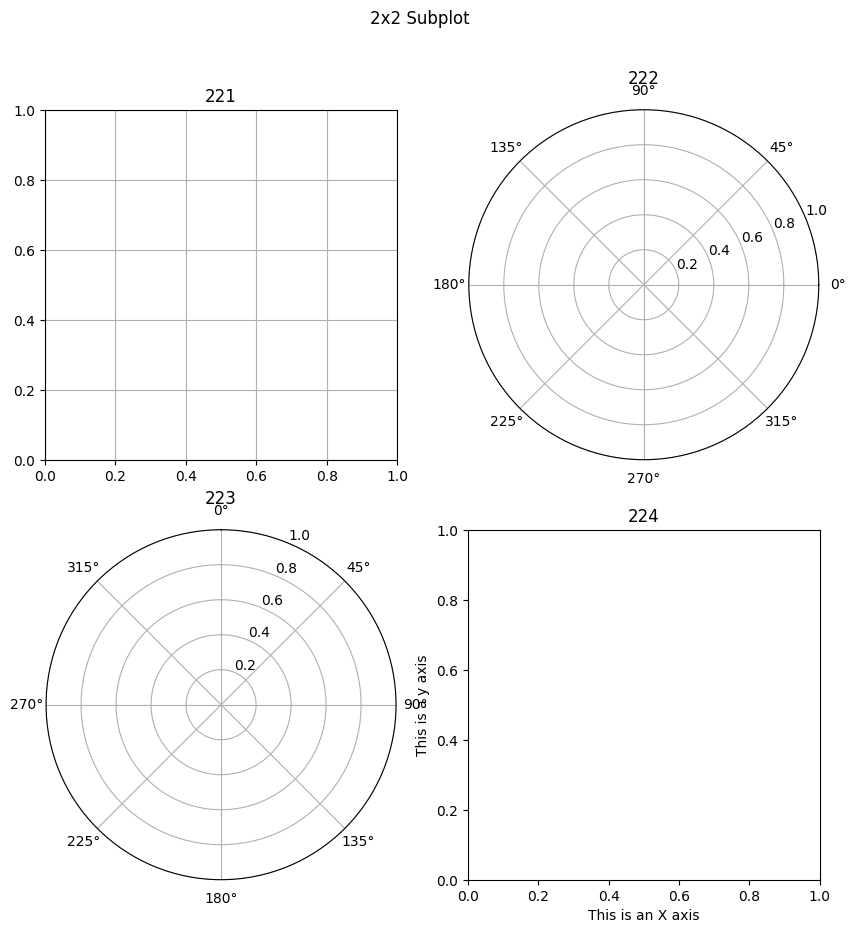

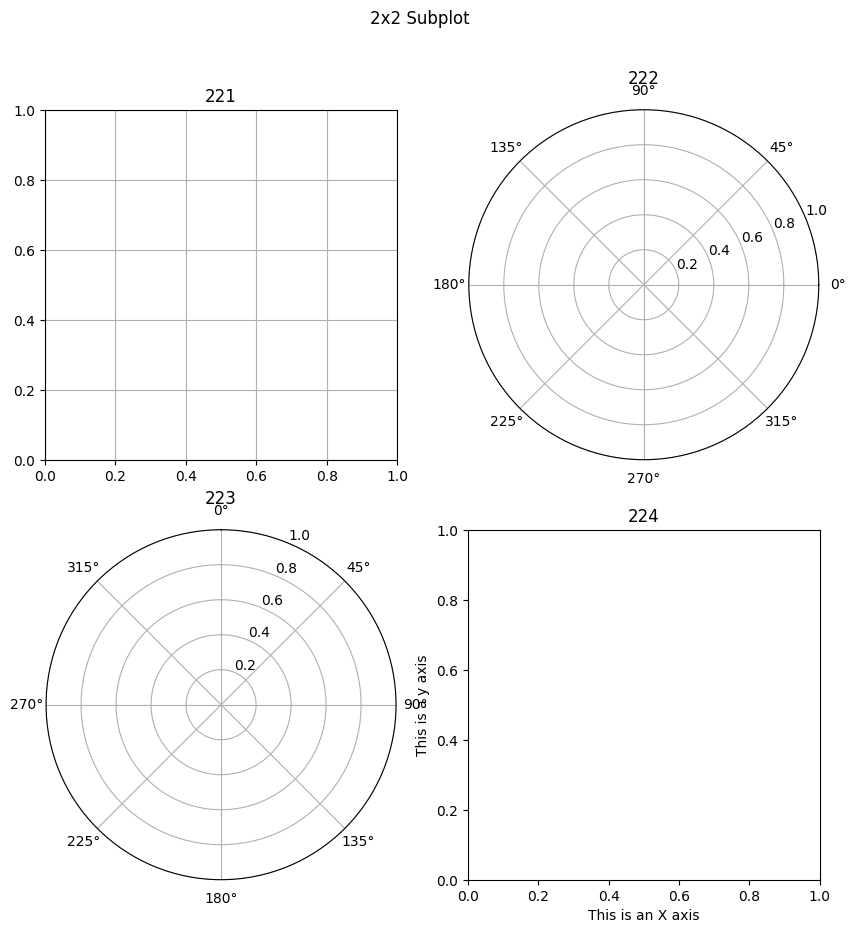

In [23]:
using PyPlot
ioff() # Interactive plotting OFF, necessary for inline plotting in IJulia

#####################
##  2x2 Plot Grid  ##
#####################
fig = figure("pyplot_subplot_mixed",figsize=(10,10)) # Create a new blank figure
#fig[:set_figheight](7) # Doesn't work
#fig[:set_figwidth](3) # Doesn't work
subplot(221) # Create the 1st axis of a 2x2 arrax of axes
grid("on") # Create a grid on the axis
title("221") # Give the most recent axis a title
subplot(222,polar="true") # Create a plot and make it a polar plot, 2nd axis of 2x2 axis grid
title("222")
ax = subplot(223,polar="true") # Create a plot and make it a polar plot, 3rd axis of 2x2 axis grid
ax[:set_theta_zero_location]("N") # Set 0 degrees to the top of the plot
ax[:set_theta_direction](-1) # Switch the polar plot to clockwise
title("223")
subplot(224) # Create the 4th axis of a 2x2 arrax of axes
xlabel("This is an X axis")
ylabel("This is a y axis")
title("224")
fig[:canvas][:draw]() # Update the figure
suptitle("2x2 Subplot")
gcf() # Needed for IJulia to plot inline